# El fijador de precios de productos (continuación)

Un modelo que puede estimar cuánto cuesta algo a partir de su descripción.

## Curación de datos, parte 2

Hoy ampliaremos nuestro conjunto de datos para que tenga una mayor cobertura y lo convertiremos en un excelente conjunto de datos para el entrenamiento.

El conjunto de datos está aquí:
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023

Y la carpeta con todos los conjuntos de datos de productos está aquí:
https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023/tree/main/raw/meta_categories

## Nota importante: léame primero, por favor

Estamos a punto de crear un conjunto de datos masivo de 400 000 artículos que abarcan varios tipos de productos. En la semana 7, usaremos estos datos para entrenar nuestro propio modelo. Es un conjunto de datos bastante grande y, según la GPU que selecciones, el entrenamiento podría llevar más de 20 horas. Será muy divertido, pero podría costar unos pocos dólares en unidades de cómputo.

Como alternativa, si quieres que todo sea rápido y económico, puedes trabajar con un conjunto de datos más pequeño centrado únicamente en electrodomésticos. Podrás cubrir los mismos puntos de aprendizaje; los resultados serán buenos, no tan buenos como el conjunto de datos completo, ¡pero aún así bastante sorprendentes! Si prefieres hacer esto, he configurado un cuaderno Jupyter alternativo en esta carpeta llamado `lite.ipynb` que deberías usar en lugar de este.

In [1]:
# imports

import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
from items import Item
from loaders import ItemLoader
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle

In [2]:
# environment

load_dotenv()
os.environ['OPENAI_API_KEY'] = os.getenv('OPENAI_API_KEY', 'your-key-if-not-using-env')
os.environ['ANTHROPIC_API_KEY'] = os.getenv('ANTHROPIC_API_KEY', 'your-key-if-not-using-env')
os.environ['HF_TOKEN'] = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
# Log in en HuggingFace

hf_token = os.environ['HF_TOKEN']
login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
%matplotlib inline

## El código de ItemLoader

Mira en loaders.py: hay un código útil que nos hará la vida más fácil

In [5]:
# Cargar el mismo conjunto de datos que la última vez

items = ItemLoader("Appliances").load()

Loading dataset Appliances


README.md:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

100%|███████████████████████████████████████████| 95/95 [00:06<00:00, 13.60it/s]


Completed Appliances with 28,625 datapoints in 0.2 mins


In [8]:
# Buscamos un objeto familiar.
print(items[1].prompt)

¿Cuánto cuesta esto redondeado al dólar más cercano?

Door Pivot Block - Compatible Kenmore KitchenAid Maytag Whirlpool Refrigerator - Replaces - Quick DIY Repair Solution
Pivot Block For Vernicle Mullion Strip On Door - A high-quality exact equivalent for part numbers and Compatibility with major brands - Door Guide is compatible with Whirlpool, Amana, Dacor, Gaggenau, Hardwick, Jenn-Air, Kenmore, KitchenAid, and Maytag. Quick DIY repair - Refrigerator Door Guide Pivot Block Replacement will help if your appliance door doesn't open or close. Wear work gloves to protect your hands during the repair process. Attentive support - If you are uncertain about whether the block fits your refrigerator, we will help. We generally put forth a valiant effort to guarantee you are totally

Price is $17.00


## Ahora, a ESCALA AMPLIA

Veamos todos los conjuntos de datos de todos los artículos que puede encontrar en una gran tienda minorista para el hogar: artículos eléctricos, electrónicos, de oficina y relacionados, pero no ropa, belleza ni libros.

In [9]:
dataset_names = [
    "Automotive",
    "Electronics",
    "Office_Products",
    "Tools_and_Home_Improvement",
    "Cell_Phones_and_Accessories",
    "Toys_and_Games",
    "Appliances",
    "Musical_Instruments",
]

In [10]:
items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

# ¡Ahora es hora de tomar un café!
# Por cierto, puse los conjuntos de datos más grandes primero... es más rápido.

Loading dataset Automotive


meta_Automotive.jsonl:   0%|          | 0.00/5.35G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|███████████████████████████████████████| 2004/2004 [02:37<00:00, 12.73it/s]


Completed Automotive with 911,688 datapoints in 7.6 mins
Loading dataset Electronics


meta_Electronics.jsonl:   0%|          | 0.00/5.25G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|███████████████████████████████████████| 1611/1611 [01:32<00:00, 17.34it/s]


Completed Electronics with 443,473 datapoints in 6.0 mins
Loading dataset Office_Products


meta_Office_Products.jsonl:   0%|          | 0.00/2.15G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|█████████████████████████████████████████| 711/711 [00:43<00:00, 16.22it/s]


Completed Office_Products with 240,394 datapoints in 2.7 mins
Loading dataset Tools_and_Home_Improvement


meta_Tools_and_Home_Improvement.jsonl:   0%|          | 0.00/4.85G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|███████████████████████████████████████| 1474/1474 [01:42<00:00, 14.38it/s]


Completed Tools_and_Home_Improvement with 541,051 datapoints in 6.0 mins
Loading dataset Cell_Phones_and_Accessories


meta_Cell_Phones_and_Accessories.jsonl:   0%|          | 0.00/4.02G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|███████████████████████████████████████| 1289/1289 [00:55<00:00, 23.24it/s]


Completed Cell_Phones_and_Accessories with 238,869 datapoints in 4.6 mins
Loading dataset Toys_and_Games


meta_Toys_and_Games.jsonl:   0%|          | 0.00/2.64G [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|█████████████████████████████████████████| 891/891 [00:59<00:00, 15.05it/s]


Completed Toys_and_Games with 340,479 datapoints in 3.5 mins
Loading dataset Appliances


100%|███████████████████████████████████████████| 95/95 [00:06<00:00, 15.30it/s]


Completed Appliances with 28,625 datapoints in 0.1 mins
Loading dataset Musical_Instruments


meta_Musical_Instruments.jsonl:   0%|          | 0.00/632M [00:00<?, ?B/s]

Generating full split: 0 examples [00:00, ? examples/s]

100%|█████████████████████████████████████████| 214/214 [00:12<00:00, 16.94it/s]


Completed Musical_Instruments with 66,829 datapoints in 0.8 mins


In [11]:
print(f"En total hay {len(items):,} ítems")

En total hay 2,811,408 ítems


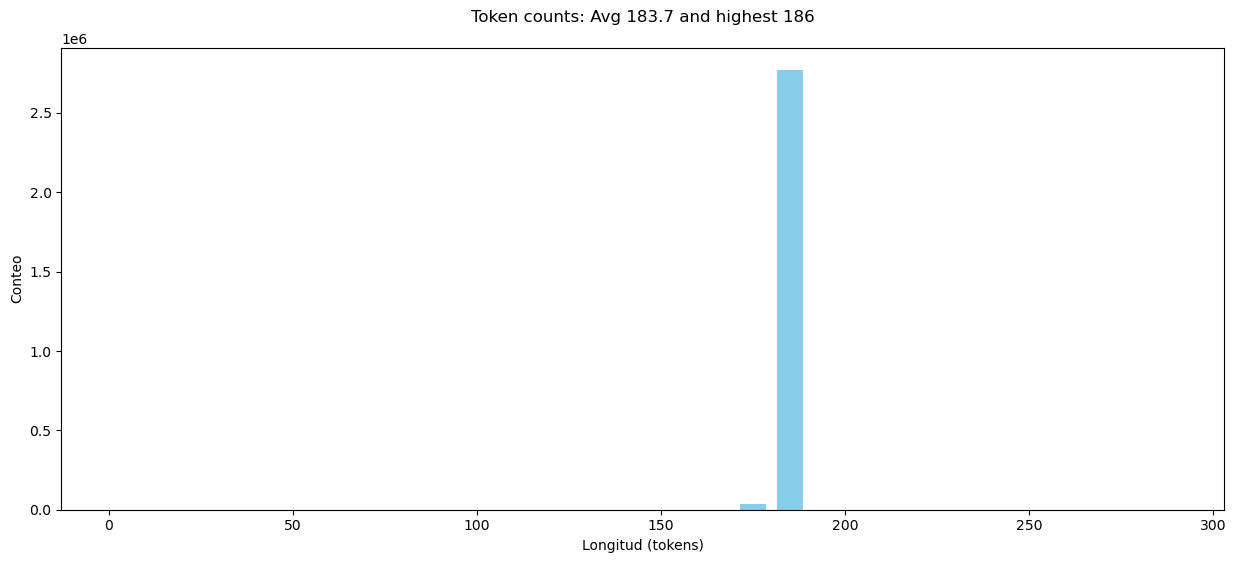

In [12]:
# Representa nuevamente la distribución de los recuentos de tokens

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token counts: Avg {sum(tokens)/len(tokens):,.1f} and highest {max(tokens):,}\n")
plt.xlabel('Longitud (tokens)')
plt.ylabel('Conteo')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

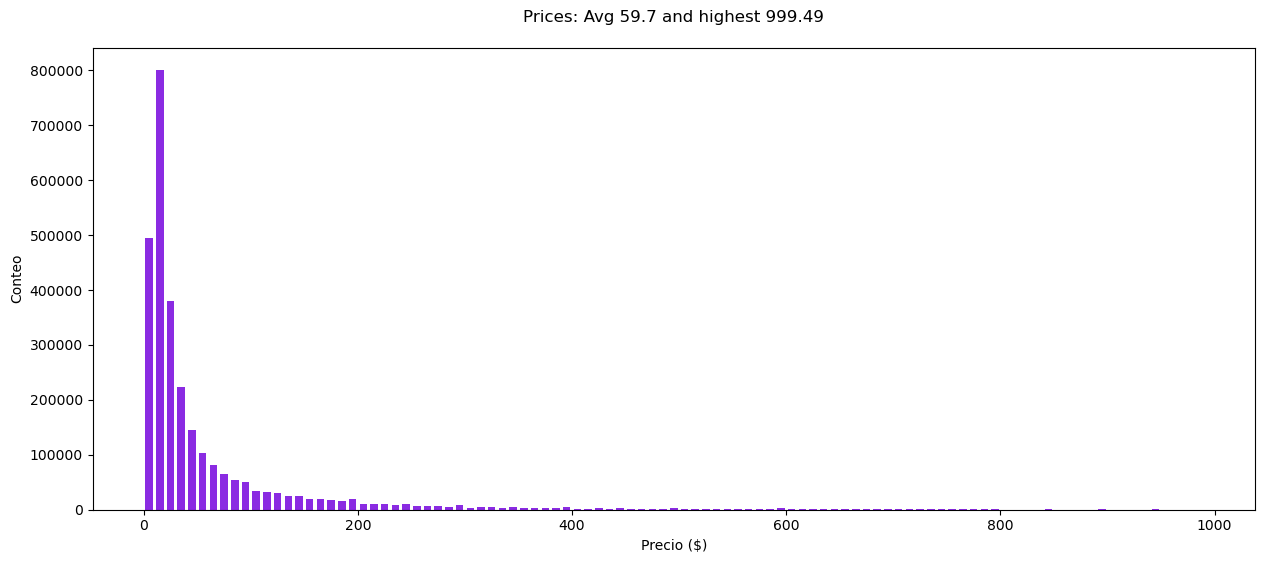

In [13]:
# Representa la distribución de los precios

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Prices: Avg {sum(prices)/len(prices):,.1f} and highest {max(prices):,}\n")
plt.xlabel('Precio ($)')
plt.ylabel('Conteo')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

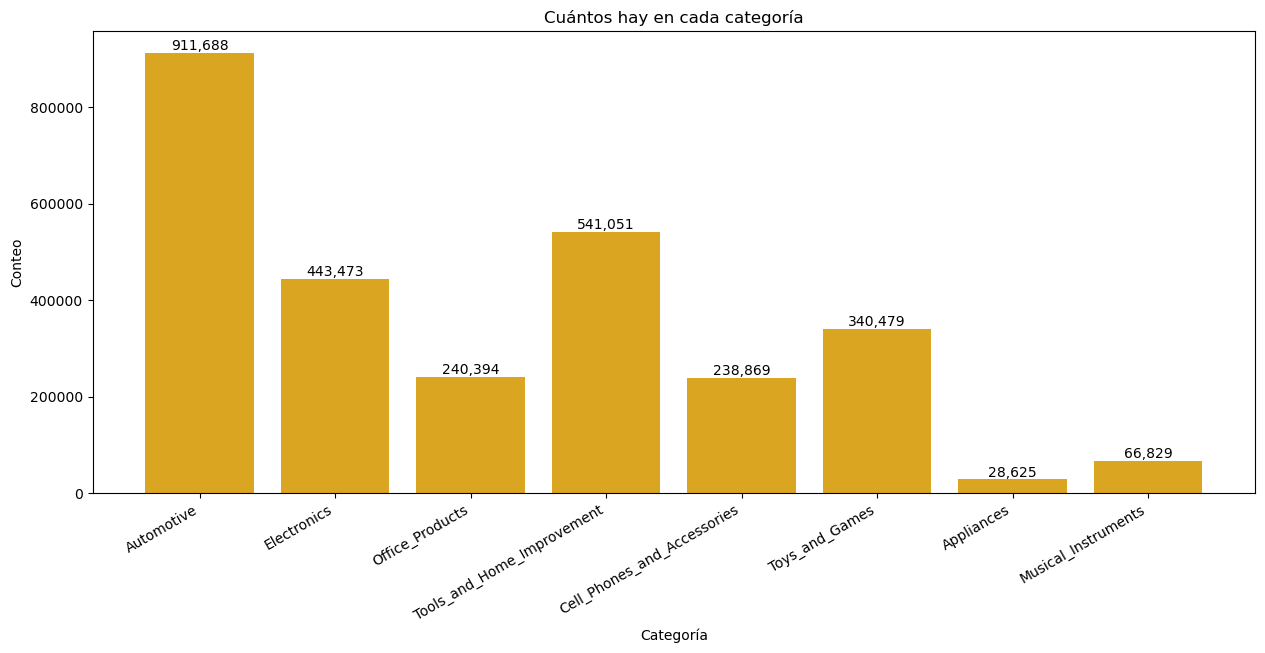

In [14]:
category_counts = Counter()
for item in items:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Bar chart por category
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="goldenrod")
plt.title('Cuántos hay en cada categoría')
plt.xlabel('Categoría')
plt.ylabel('Conteo')

plt.xticks(rotation=30, ha='right')

# Agrega etiquetas de valor en la parte superior de cada barra
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Display the chart
plt.show()

# Objetivo

Elaborar un conjunto de datos que esté más equilibrado en términos de precios. Menos sesgado hacia artículos baratos, con un promedio superior a $60. Intentar equilibrar las categorías: menos artículos de automoción.

In [15]:
# Crea un diccionario con una clave de cada precio desde $1 hasta $999
# Y en el valor, coloca una lista de artículos con ese precio (redondeado al número más cercano)

slots = defaultdict(list)
for item in items:
    slots[round(item.price)].append(item)

In [16]:
# Cree un conjunto de datos llamado "muestra" que intente tomar de manera más uniforme el rango de precios
# Y otorgue más peso a los artículos de categorías distintas a la de Automotriz
# Establezca una semilla aleatoria para la reproducibilidad

np.random.seed(42)
random.seed(42)
sample = []
for i in range(1, 1000):
    slot = slots[i]
    if i>=240:
        sample.extend(slot)
    elif len(slot) <= 1200:
        sample.extend(slot)
    else:
        weights = np.array([1 if item.category=='Automotive' else 5 for item in slot])
        weights = weights / np.sum(weights)
        selected_indices = np.random.choice(len(slot), size=1200, replace=False, p=weights)
        selected = [slot[i] for i in selected_indices]
        sample.extend(selected)

print(f"Hay {len(sample):,} ítems en la muestra aleatoria")

Hay 408,635 ítems en la muestra aleatoria


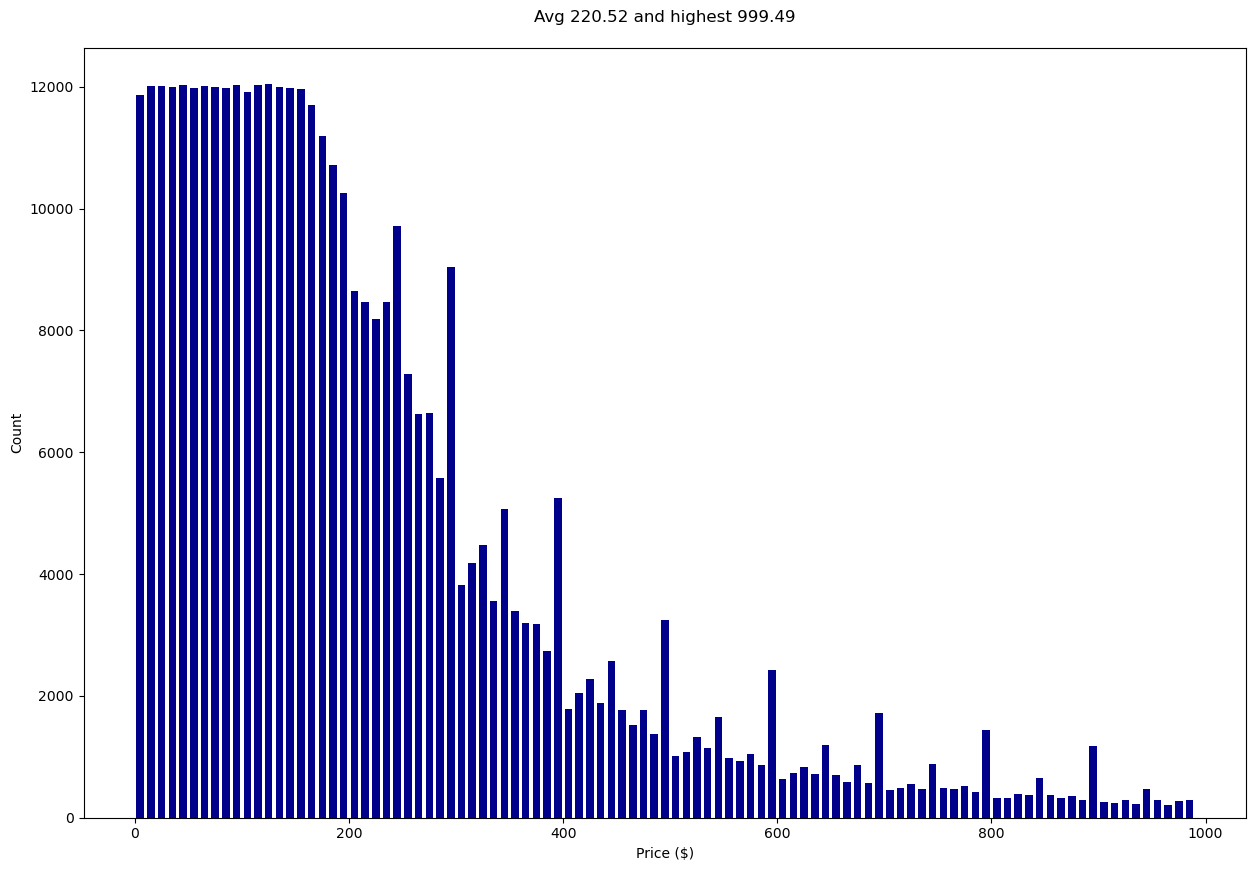

In [17]:
# Representar la distribución de precios en la muestra

prices = [float(item.price) for item in sample]
plt.figure(figsize=(15, 10))
plt.title(f"Avg {sum(prices)/len(prices):.2f} and highest {max(prices):,.2f}\n")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

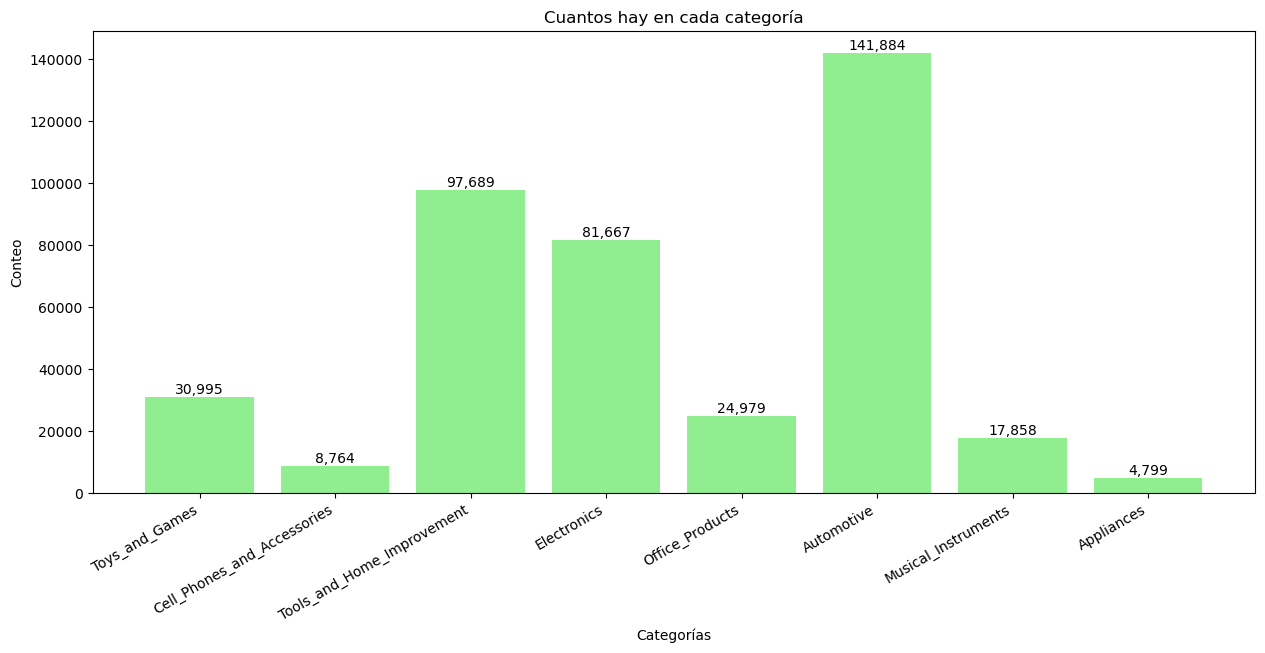

In [18]:
# Bien, lo hicimos bien en términos de aumentar el precio promedio y tener una población de precios bastante estable
# Veamos las categorías

category_counts = Counter()
for item in sample:
    category_counts[item.category]+=1

categories = category_counts.keys()
counts = [category_counts[category] for category in categories]

# Create bar chart
plt.figure(figsize=(15, 6))
plt.bar(categories, counts, color="lightgreen")

# Customize the chart
plt.title('Cuantos hay en cada categoría')
plt.xlabel('Categorías')
plt.ylabel('Conteo')

plt.xticks(rotation=30, ha='right')

# Agregamos etiquetas de valores en la parte superior de cada barra
for i, v in enumerate(counts):
    plt.text(i, v, f"{v:,}", ha='center', va='bottom')

# Mostramos el gráfico
plt.show()

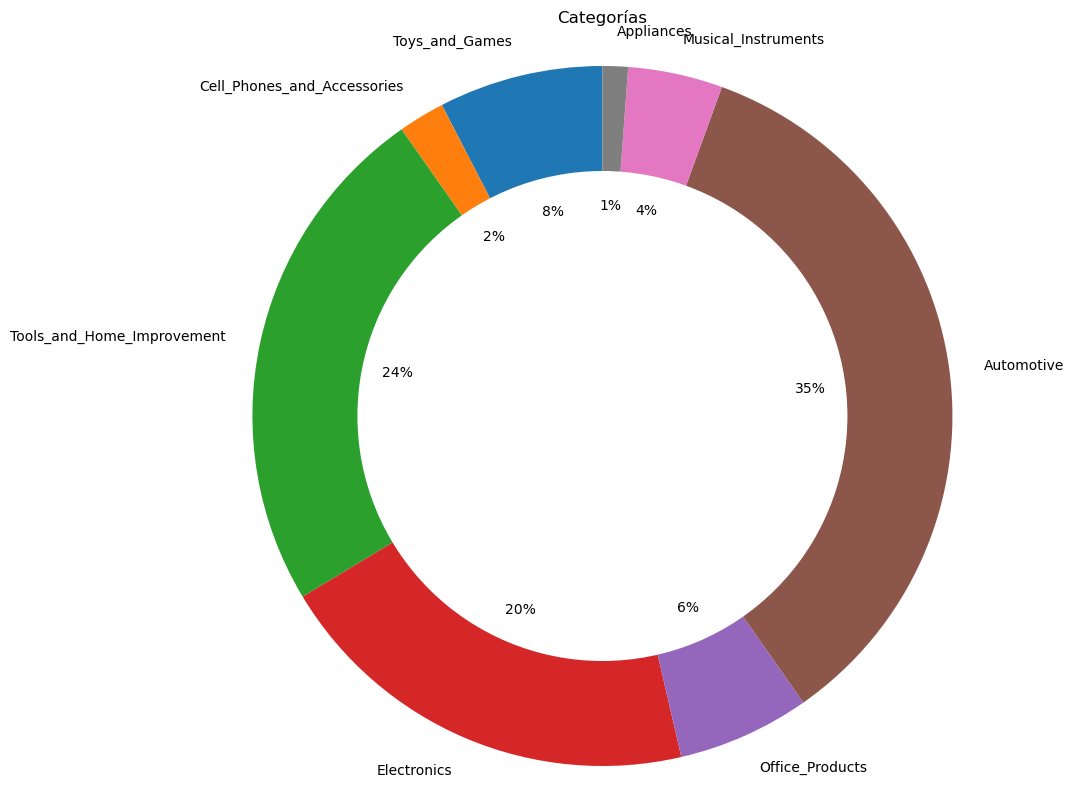

In [19]:
# El sector automovilístico sigue a la cabeza, pero ha mejorado un poco
# Para tener otra perspectiva, veamos un gráfico circular

plt.figure(figsize=(12, 10))
plt.pie(counts, labels=categories, autopct='%1.0f%%', startangle=90)

# Agrega un círculo en el centro para crear un gráfico de anillos (opcional)
centre_circle = plt.Circle((0,0), 0.70, fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
plt.title('Categorías')

# La relación de aspecto igual garantiza que el gráfico circular se dibuje como un círculo
plt.axis('equal')  

plt.show()

# ¡Conjunto de datos seleccionado!

Hemos creado un excelente conjunto de datos.

Hagamos algunas comprobaciones finales

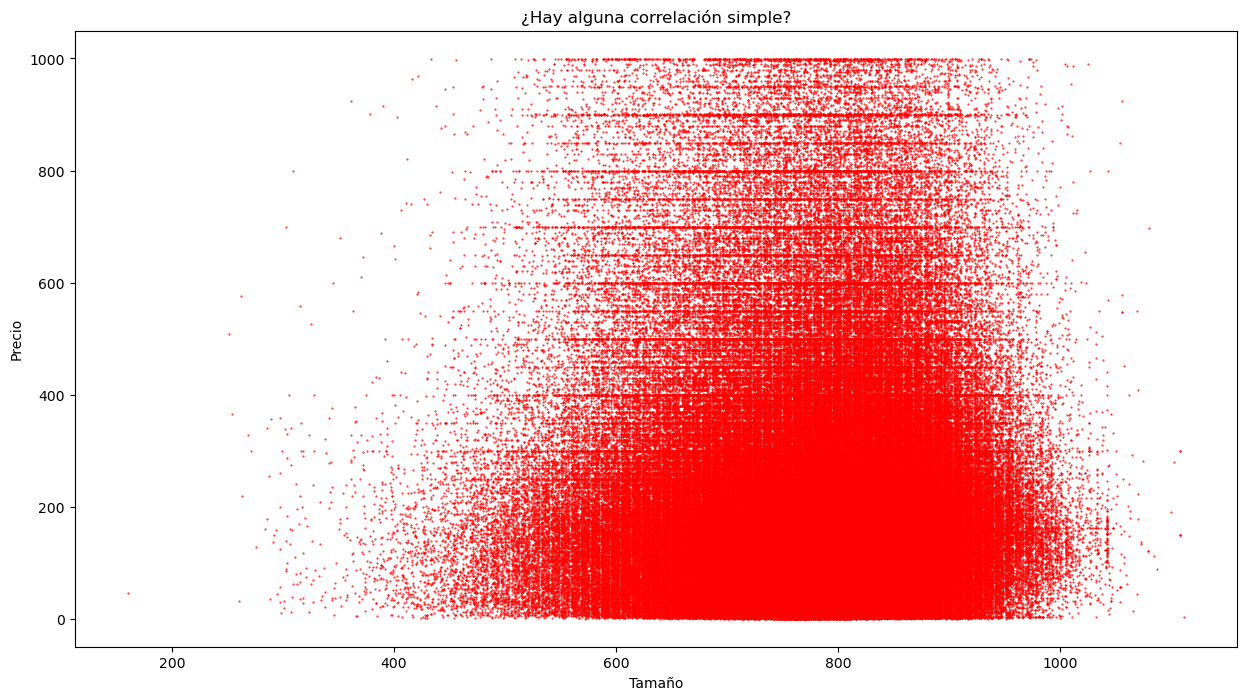

In [20]:
# ¿Cómo varía el precio con el número de caracteres del mensaje?

sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]

# Creamos el scatter plot
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")

# Añadimos labels y título
plt.xlabel('Tamaño')
plt.ylabel('Precio')
plt.title('¿Hay alguna correlación simple?')

# Representamos el gráfico
plt.show()

In [21]:
def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [26]:
report(sample[398000])

¿Cuánto cuesta esto redondeado al dólar más cercano?

MonoRS Coilovers Lowering Kit Made For Scion FRS Fully Adjustable, Set of 4
MonoRS Coilover damper kit by Godspeed Project are intermediate suspension upgrade setup for daily and Sunday club racing. Lowering your car with improved springs over factory and paired with Mono-tubo shocks with valving that allows 32 levels of rebound adjustment to improve handling without sacrifice comfort. Ride height can easily be adjusted by twisting the lower mount bracket. In order to keep weight gain at the minimum, most of attachments and accessories are CNC machined from billet aluminum. Koyo bearings are used when camber plate top mount is applicable depends on car models. To assure that our customers are getting high quality products, MonoRS coilovers are covered by 12 months limited warranty by the manufacturer from

Price is $765.00
[279, 14290, 505, 271, 7117, 374, 400, 22240, 13, 410]
[' the', ' manufacturer', ' from', '\n\n', 'Price', ' is

## Observación

Una característica interesante del tokenizador de Llama es que cada número del 1 al 999 se asigna a un token, de forma muy similar a lo que vimos con gpt-4o. No ocurre lo mismo con qwen2, gemma y phi3, que asignan dígitos individuales a tokens. Esto resulta ser un poco útil para nuestro proyecto, aunque no es un requisito esencial.

# Finalmente

Es hora de dividir nuestros datos en un conjunto de datos de entrenamiento, prueba y validación.

Lo habitual es utilizar entre el 5 % y el 10 % de los datos para fines de prueba, pero en realidad tenemos mucho más de lo que necesitamos en este momento. Tomaremos 400 000 puntos para entrenamiento y reservaremos 2000 para pruebas, aunque no los utilizaremos todos.

In [27]:
random.seed(42)
random.shuffle(sample)
train = sample[:400_000]
test = sample[400_000:402_000]
print(f"Dividido en un conjunto de entrenamiento de {len(train):,} elementos y un conjunto de prueba de {len(test):,} elementos")

Dividido en un conjunto de entrenamiento de 400,000 elementos y un conjunto de prueba de 2,000 elementos


In [28]:
print(train[0].prompt)

¿Cuánto cuesta esto redondeado al dólar más cercano?

Delphi FG0166 Fuel Pump Module
Delphi brings 80 years of OE Heritage into each Delphi pump, ensuring quality and fitment for each Delphi part. Part is validated, tested and matched to the right vehicle application Delphi brings 80 years of OE Heritage into each Delphi assembly, ensuring quality and fitment for each Delphi part Always be sure to check and clean fuel tank to avoid unnecessary returns Rigorous OE-testing ensures the pump can withstand extreme temperatures Brand Delphi, Fit Type Vehicle Specific Fit, Dimensions LxWxH 19.7 x 7.7 x 5.1 inches, Weight 2.2 Pounds, Auto Part Position Unknown, Operation Mode Mechanical, Manufacturer Delphi, Model FUEL PUMP, Dimensions 19.7

Price is $227.00


In [29]:
print(test[0].test_prompt())

¿Cuánto cuesta esto redondeado al dólar más cercano?

OEM AC Compressor w/A/C Repair Kit For Ford F150 F-150 V8 & Lincoln Mark LT 2007 2008 - BuyAutoParts NEW
As one of the world's largest automotive parts suppliers, our parts are trusted every day by mechanics and vehicle owners worldwide. This A/C Compressor and Components Kit is manufactured and tested to the strictest OE standards for unparalleled performance. Built for trouble-free ownership and 100% visually inspected and quality tested, this A/C Compressor and Components Kit is backed by our 100% satisfaction guarantee. Guaranteed Exact Fit for easy installation 100% BRAND NEW, premium ISO/TS 16949 quality - tested to meet or exceed OEM specifications Engineered for superior durability, backed by industry-leading unlimited-mileage warranty Included in this K

Price is $


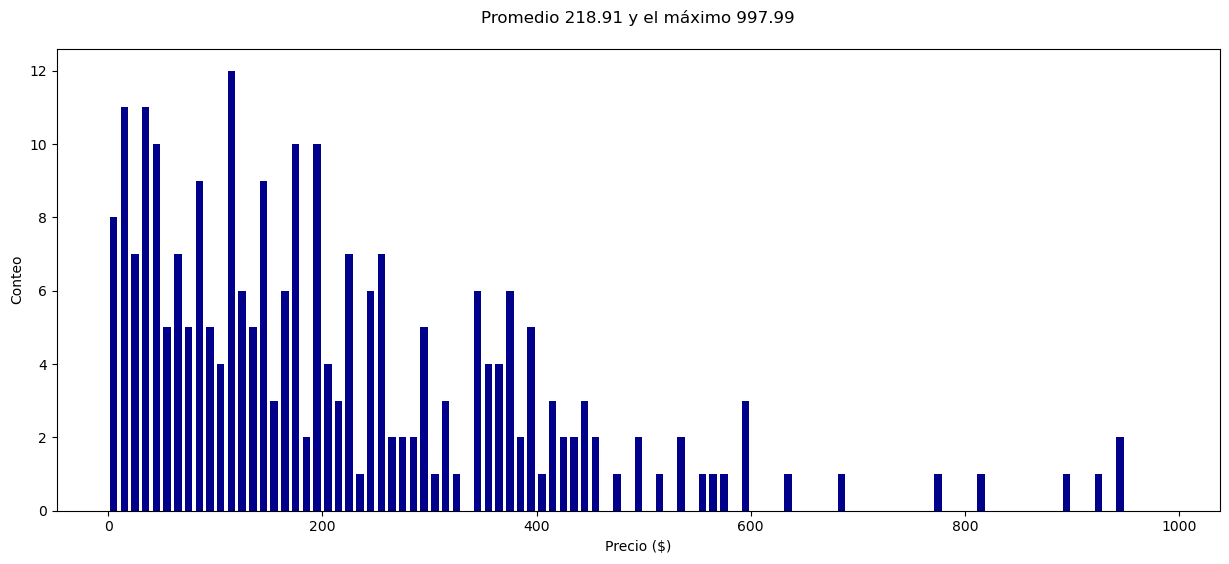

In [30]:
# Representamos la distribución de precios en los primeros 250 puntos de prueba

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Promedio {sum(prices)/len(prices):.2f} y el máximo {max(prices):,.2f}\n")
plt.xlabel('Precio ($)')
plt.ylabel('Conteo')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

# Finalmente, cargue su nuevo conjunto de datos

Conviértalo en indicaciones y cárguelo en el centro de HuggingFace

In [31]:
train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [32]:
# Creamos el Dataset a partir de las listas

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [33]:
# Descomenta estas líneas si está listo para enviarlas al centro y reemplaza mi nombre con su nombre de usuario de HF

HF_USER = "joanby"
DATASET_NAME = f"{HF_USER}/pricer-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/400 [00:00<?, ?ba/s]

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

CommitInfo(commit_url='https://huggingface.co/datasets/joanby/pricer-data/commit/fa5cd941a8f0a3c70e81512f3c2a2199ee52d6cf', commit_message='Upload dataset', commit_description='', oid='fa5cd941a8f0a3c70e81512f3c2a2199ee52d6cf', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/joanby/pricer-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='joanby/pricer-data'), pr_revision=None, pr_num=None)

In [34]:
# ¡Una cosa más!
# ¡Agreguemos los conjuntos de datos de entrenamiento y prueba para no tener que ejecutar todo este código la próxima vez!

with open('train.pkl', 'wb') as file:
    pickle.dump(train, file)

with open('test.pkl', 'wb') as file:
    pickle.dump(test, file)

## Tareas pendientes para ti:

- ¡Investiga más el conjunto de datos!
- Confirma que el tokenizador convierte los precios de 3 dígitos en 1 token